In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display
from scipy.stats import pearsonr
import seaborn as sns
from scipy.optimize import nnls  # for non-negative least squares
from scipy.stats import linregress
import matplotlib.patches as mpatches
from pathlib import Path
import sys
from statsmodels.tsa.statespace.sarimax import SARIMAX


rc('mathtext', default='regular')
sys.path.append(str(Path('..').resolve()))
from fun_LR_hydro_memory import *

# === Paths ===
project_root = Path.cwd().resolve()
data_dir = '../../data/ms_data/'
out_results = 'csv'
Path(out_results).mkdir(parents=True, exist_ok=True)

# === Global parameters ===
min_obs = 100

# === Training period for LR ===
train_start = '1960-01-01'

train_end   = '2025-12-31'
label_train = 'trained_all'

# train_end   = '2010-12-31'
# label_train = 'trained_pre_MD'

# === Load data ==
gw_all = pd.read_csv(data_dir + 'wells_gw.csv', parse_dates=['date'])
pr_all = pd.read_csv(data_dir + 'wells_pr.csv', parse_dates=['date'])
et_all = pd.read_csv(data_dir + 'wells_et.csv', parse_dates=['date'])

clean_codes = [col for col in gw_all.columns if col != 'date']
start = gw_all['date'].min()
end = gw_all['date'].max()

r2_summary_all = pd.DataFrame(columns=[
    'well_id',
    'target',
    'predictor',
    'lag_type',
    'lag_incr_rule',
    'lag_incr',
    'r2_train',
    'r2_all',
    'has_neg_coef'
])

# === Control for overwriting the prediction CSV on first write ===
predictions_file = out_results + '/gw_sim_SARIMAX_' + label_train + '.csv'
overwrite_predictions = True  # Will be set to False after first write

# === Loop through wells with ≥ min obs ===
# for cod in ['03450005','05731003', '05410014']:
# for cod in ['03450005']:
for cod in clean_codes:
    gw = pd.Series(gw_all[cod].values, index=gw_all['date'])
    if gw.notna().sum() < min_obs:
        continue  # Skip well
    pr = pd.Series(pr_all[cod].values, index=pr_all['date'])
    et = pd.Series(et_all[cod].values, index=et_all['date'])

    # Align time
    gw, pr , et = gw[start:end], pr[start:end], et[start:end]

    if gw.notna().sum() < min_obs:
        continue  # Skip well
        
    # === Compute monthly anomalies (deseasonalize) === (computed again in case the training period is not the full period of recrd)
    gw_an = gw - gw.groupby(gw.index.month).transform('mean')
    pr_an = pr - pr.groupby(pr.index.month).transform('mean')
    et_an = et - et.groupby(et.index.month).transform('mean')

    # === De-trend ===
    # GW Detrend
    x_gw = np.arange(len(gw_an))
    y_gw = gw_an.values
    mask_gw = ~np.isnan(y_gw)
    
    # GW Linear trend
    gw_coeffs_lin = np.polyfit(x_gw[mask_gw], y_gw[mask_gw], deg=1)
    gw_trend_lin = np.polyval(gw_coeffs_lin, x_gw)
    gw_an_dt = y_gw - gw_trend_lin
    # GW Linear trend only if significant
    slope, intercept, r_value, p_value, std_err = linregress(x_gw[mask_gw], y_gw[mask_gw])
    if (slope < 0) and (p_value < 0.05):
        gw_an_dt_sig = y_gw - (slope * x_gw + intercept)
    else:
        gw_an_dt_sig = y_gw  # just the anomaly, not detrended

    # Pr Detrend
    x_pr = np.arange(len(pr_an))
    y_pr = pr_an.values
    mask_pr = ~np.isnan(y_pr)
    pr_coeffs_lin = np.polyfit(x_pr[mask_pr], y_pr[mask_pr], deg=1)
    pr_trend_lin = np.polyval(pr_coeffs_lin, x_pr)
    pr_an_dt = y_pr - pr_trend_lin

    # ET Detrend
    x_et = np.arange(len(et_an))
    y_et = et_an.values
    mask_et = ~np.isnan(y_et)
    et_coeffs_lin = np.polyfit(x_et[mask_et], y_et[mask_et], deg=1)
    et_trend_lin = np.polyval(et_coeffs_lin, x_et)
    et_an_dt = y_et - et_trend_lin  

    ### Create predictors for LR (moving window mean precip)
    pr_an_dt = pd.Series(pr_an_dt, index=pr.index, name='an_dt')
    pr_an = pd.Series(pr_an, index=pr.index, name='an')    
    et_an_dt = pd.Series(et_an_dt, index=et.index, name='an_dt')
    et_an = pd.Series(et_an, index=et.index, name='an')   

    n_pred = 6

    lag_configs = [
        {"incr_type": 1, "lag_increase": 4},
        {"incr_type": 2, "lag_increase": 4},
        {"incr_type": 3, "lag_increase": 2}
    ]

    lag_ranges_all = {}
    
    for config in lag_configs:
        incr_type = config["incr_type"]
        lag_increase = config["lag_increase"]
        lag_type_label = f"type{incr_type}_incr{lag_increase}"
        
        lag_ranges, widths, incr_name = make_lag_ranges(
            lag_increase=lag_increase,
            n_windows=n_pred,
            incr_type=incr_type
        )

        # precip
        # pred_pr_raw   = rolling_predictors(pr, lag_ranges, standardize=True)
        pred_pr_an_dt = rolling_predictors(pr_an_dt, lag_ranges, standardize=True)
        pred_pr_an    = rolling_predictors(pr_an,    lag_ranges, standardize=True)

#         # ET too
#         pred_et_an_dt = rolling_predictors(et_an_dt, lag_ranges, standardize=True)
#         pred_et_an    = rolling_predictors(et_an,    lag_ranges, standardize=True)

        # --- Targets ---
        targets = {
            'gw_an': pd.Series(gw_an, name='gw_an', index=gw_an.index),
            'gw_an_dt': pd.Series(gw_an_dt, name='gw_an_dt', index=gw_an.index)
        }

        # --- Predictor/target combinations ---
        combinations = [
            ('gw_an', 'pr_an', pred_pr_an, 'GW_an=linreg(P_an)'),
            ('gw_an', 'pr_an_dt', pred_pr_an_dt, 'GW_an=linreg(P_an_dt)'),
            ('gw_an_dt', 'pr_an_dt', pred_pr_an_dt, 'GW_an_dt=linreg(P_an_dt)')
        ]
      
        coeffs_df = pd.DataFrame()

        ############# IMPORTANT TO SET TUP #########
        # Set to True to restrict to non-negative coefficients (kept for completeness)
        restrict_positive = False

        for i, (target_name, pred_name, pred_df, label) in enumerate(combinations):
                        
            y = targets[target_name]
            predictors_full = pred_df.loc[y.index]
            df_full = pd.concat([y, predictors_full], axis=1).dropna()
            if df_full.empty:
                continue

            df_train = df_full.loc[train_start:train_end]
            if df_train.shape[0] < min_obs:
                continue  # Skip well

            y_train = df_train[target_name]
            X_train = df_train.drop(columns=target_name)

            model = SARIMAX(
                endog=y_train,
                exog=X_train,
                order=(1, 0, 0),
                seasonal_order=(0, 0, 0, 0),
                trend='c',
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)

            coeffs_df[label] = res.params

            y_pred_series = pd.Series(np.nan, index=df_full.index, dtype=float)
            y_pred_series.loc[df_train.index] = res.fittedvalues

            if df_full.shape[0] > df_train.shape[0]:
                X_future = df_full.drop(columns=target_name).iloc[df_train.shape[0]:]
                if not X_future.empty:
                    forecast = res.get_forecast(steps=X_future.shape[0], exog=X_future)
                    y_pred_series.iloc[df_train.shape[0]:] = forecast.predicted_mean.values

            y_pred_full = pd.Series(np.nan, index=y.index, dtype=float)
            y_pred_full.loc[df_full.index] = y_pred_series

            pred_out = pd.DataFrame({
                "date": y.index,
                "well_id": cod,
                "target": target_name,
                "predictor": pred_name,
                "lr_label": label,
                "lag_type":lag_type_label,
                "lag_incr_rule": incr_name,
                "lag_incr": lag_increase,
                "raw_obs": gw,
                "target_val": y.values,
                "pred": y_pred_full.values
            })

            pred_out.to_csv(
                predictions_file,
                mode='w' if overwrite_predictions else 'a',
                header=overwrite_predictions,
                index=False
            )
            overwrite_predictions = False  # After first write, switch to append mode

            # R² (full)
            mask_all = y.notna() & y_pred_full.notna()            
            if np.std(y_pred_full[mask_all]) == 0 or np.std(y[mask_all]) == 0:
                r2_all = np.nan
            else:
                corr_all = np.corrcoef(y[mask_all], y_pred_full[mask_all])[0, 1]
                r2_all = corr_all**2 if not np.isnan(corr_all) else np.nan
    
            # R² (train)
            y_pred_train = y_pred_full.loc[train_start:train_end]
            mask_train_eval = y_pred_train.notna() & y_train.notna()
            if mask_train_eval.any():
                if np.std(y_pred_train[mask_train_eval]) == 0 or np.std(y_train[mask_train_eval]) == 0:
                    r2_train = np.nan
                else:
                    corr_train = np.corrcoef(y_train[mask_train_eval], y_pred_train[mask_train_eval])[0, 1]
                    r2_train = corr_train**2 if not np.isnan(corr_train) else np.nan
            else:
                r2_train = np.nan

            # Store R2 results
            has_neg = (res.params < 0).any()

            r2_summary_all = pd.concat([
            r2_summary_all,
            pd.DataFrame([{
                "well_id": cod,
                "target": target_name,
                "predictor": pred_name,
                "lr_label": label,
                "lag_type":lag_type_label,
                "lag_incr_rule": incr_name,
                "lag_incr": lag_increase,
                "r2_train": r2_train,
                "r2_all": r2_all,
                "has_neg_coef": has_neg
            }])
            ], ignore_index=True)

# Add column to identify whether this run used positive coefficient restriction
r2_summary_all['LR_restrict_positive'] = restrict_positive  # or False, depending on the run
r2_summary_all.to_csv(f"{out_results}/r2_SARIMAX_rest_pos_{r2_summary_all['LR_restrict_positive'].iloc[0]}_{label_train}.csv", index=False)     
print("\nLR models Finished! \nFinito! \nTerminado!\n")

/Users/cag/Dropbox/0_Research/0_githubs/ms_recovery/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cag/Dropbox/0_Research/0_githubs/ms_recovery/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/mm/nd9j2p7s4d1fmw46jbmnzdvr0000gn/T/ipykernel_91639/3909316782.py:258: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  r2_summary_all = pd.concat


LR models Finished! 
Finito! 
Terminado!



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_r2_by_target(df, combinations, thr_r2=0.0, title_suffix="", filename="r2_merged_targets", out_figs="figures"):
    """
    Creates a figure with:
    - Two boxplots per target (for r2_train and r2_all) showing R² per lag, grouped by predictor.
    - One bar plot showing the number of wells (y) with R² > threshold per lag (x), per combination.
    """
    # === Prep combinations info ===
    used_combos = [(t, p) for (t, p, _, _) in combinations]
    label_map = {(t, p): label for (t, p, _, label) in combinations}
    pred_label_map = {(t, p): label.split('= f (')[-1].rstrip(')') for (t, p, _, label) in combinations}
    targets = sorted(set(t for t, _, _, _ in combinations))

    # === Filter R² data ===
    df = df[df[['target', 'predictor']].apply(tuple, axis=1).isin(used_combos)].copy()
    # df = df[(df['r2_train'] > thr_r2) | (df['r2_all'] > thr_r2)]
    df = df[(df['r2_train'] > thr_r2)]
    df['combo_label'] = df.apply(lambda row: label_map.get((row['target'], row['predictor'])), axis=1)
    df['predictor_label'] = df.apply(lambda row: pred_label_map.get((row['target'], row['predictor'])), axis=1)

    # === Melt to long format for r2_train and r2_all ===
    df_long = df.melt(
        id_vars=['well_id', 'target', 'predictor', 'lag_type', 'predictor_label'],
        value_vars=['r2_train', 'r2_all'],
        var_name='r2_type',
        value_name='r2'
    )

    # === Count summary ===
    count_df = (
        df[df['r2_all'] > thr_r2]
        .groupby(['target', 'predictor', 'lag_type'])['well_id']
        .nunique()
        .reset_index(name='n_wells')
    )
    count_df['combo_label'] = count_df.apply(lambda row: label_map.get((row['target'], row['predictor'])), axis=1)

    # === Setup 3-panel figure ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    for i, t in enumerate(targets):
        ax = axs[i]
        df_plot = df_long[df_long['target'] == t]
        if df_plot.empty:
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.set_axis_off()
            continue

        sns.boxplot(
            data=df_plot,
            x='lag_type',
            y='r2',
            hue='r2_type',
            ax=ax,
            width=0.6,
            palette={'r2_train': 'skyblue', 'r2_all': 'orange'}
        )

        # Add number of wells on top
        xtick_labels = list(df_plot['lag_type'].unique())
        xtick_positions = {label: i for i, label in enumerate(xtick_labels)}
        grouped = df[df['target'] == t].groupby(['lag_type', 'predictor_label'])['well_id'].nunique().reset_index(name='count')
        for j, pred in enumerate(df['predictor_label'].unique()):
            for lag in sorted(df['lag_type'].unique()):
                subset = grouped[(grouped['lag_type'] == lag) & (grouped['predictor_label'] == pred)]
                if not subset.empty:
                    count = subset['count'].values[0]
                    xpos = xtick_positions[lag] + j * 0.15 - 0.25
                    ax.text(x=xpos, y=1.01, s=f"n={count}",
                            ha='center', va='bottom', fontsize=7, rotation=90,
                            transform=ax.get_xaxis_transform())

        ax.set_ylim(0, 1)
        ax.text(0.5, 1.13, f"Target: {t} {title_suffix}", transform=ax.transAxes, ha='center', fontsize=10)
        ax.set_xlabel("Lag type")
        ax.set_ylabel("R²" if i == 0 else "")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        if i == 0:
            ax.legend(title='R² type', fontsize=8, loc='lower right')
        else:
            ax.get_legend().remove()

    # === fourth panel: Barplot of number of wells with R² > threshold ===
    ax = axs[2]
    sns.barplot(
        data=count_df,
        x='lag_type',
        y='n_wells',
        hue='combo_label',
        ax=ax
    )
    # ax.set_ylim(0, 350)
    ax.set_title(f"# of wells with R² > {thr_r2}")
    ax.set_xlabel("lag_type")
    ax.set_ylabel("Number of Wells")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(title="Combination", fontsize=8, loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{out_figs}/{filename}.png", bbox_inches='tight')
    plt.show()




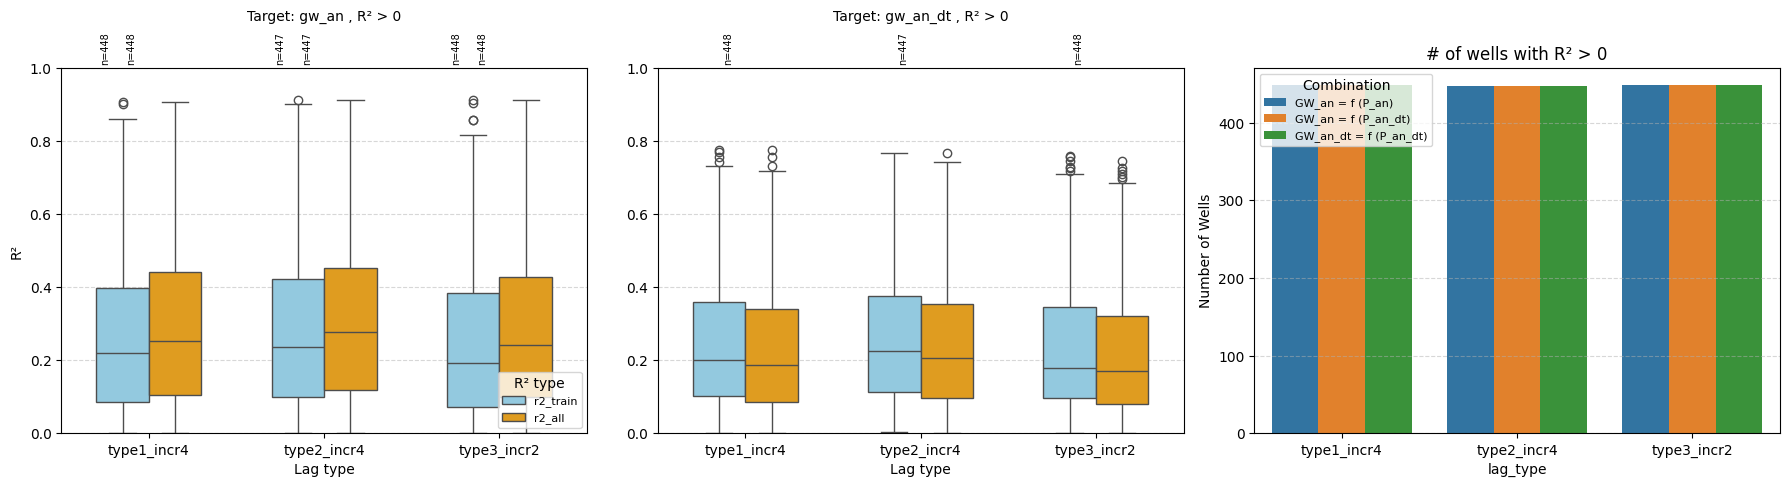

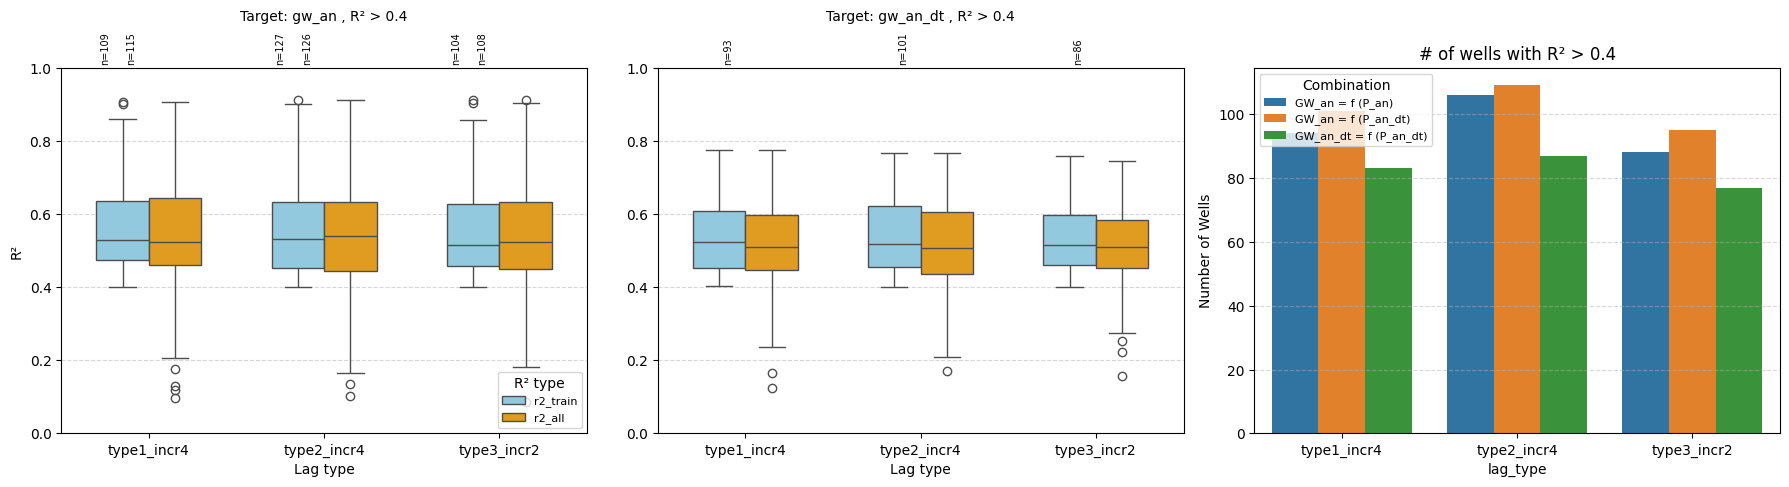

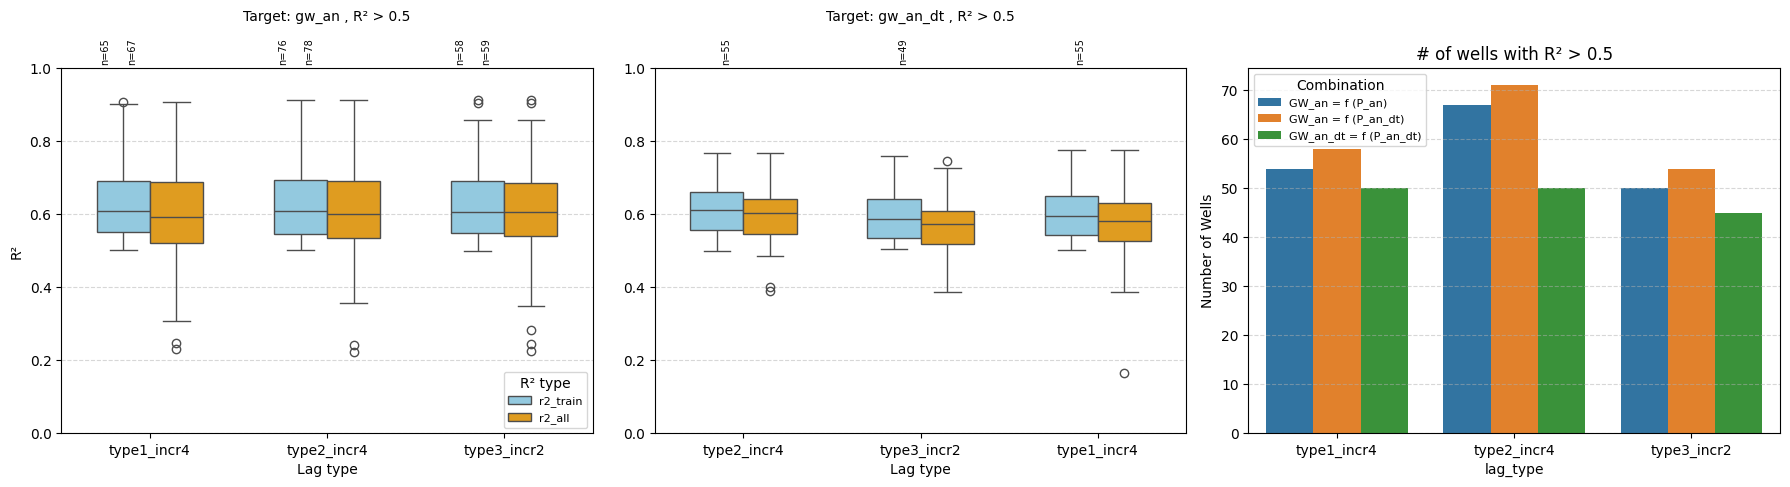

In [14]:
# === Load R² CSV ===
out_figs = 'figs_r2'
Path(out_figs).mkdir(parents=True, exist_ok=True)

# df_r2 = pd.read_csv('csv/r2_LR_rest_pos_False_trained_all.csv')  # or _False
# filename = 'r2_LR_trained_all'

df_r2 = pd.read_csv('csv/r2_LR_rest_pos_False_trained_pre_MD.csv')  # or _False
filename = 'r2_LR_trained_preMD'

# --- Predictor/target combinations ---
combinations = [
    ('gw_an', 'pr_an', None, 'GW_an = f (P_an)'),
    ('gw_an', 'pr_an_dt', None, 'GW_an = f (P_an_dt)'),
    ('gw_an_dt', 'pr_an_dt', None, 'GW_an_dt = f (P_an_dt)')
]
       
plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0,
    title_suffix=", R² > 0",
    filename= filename + "_all",
    out_figs=out_figs
)  

plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0.4,
    title_suffix=", R² > 0.4",
    filename= filename + "_0.4",
    out_figs=out_figs
) 


plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0.5,
    title_suffix=", R² > 0.5",
    filename= filename + "_0.5",
    out_figs=out_figs
) 

TypeError: unsupported operand type(s) for /: 'str' and 'str'

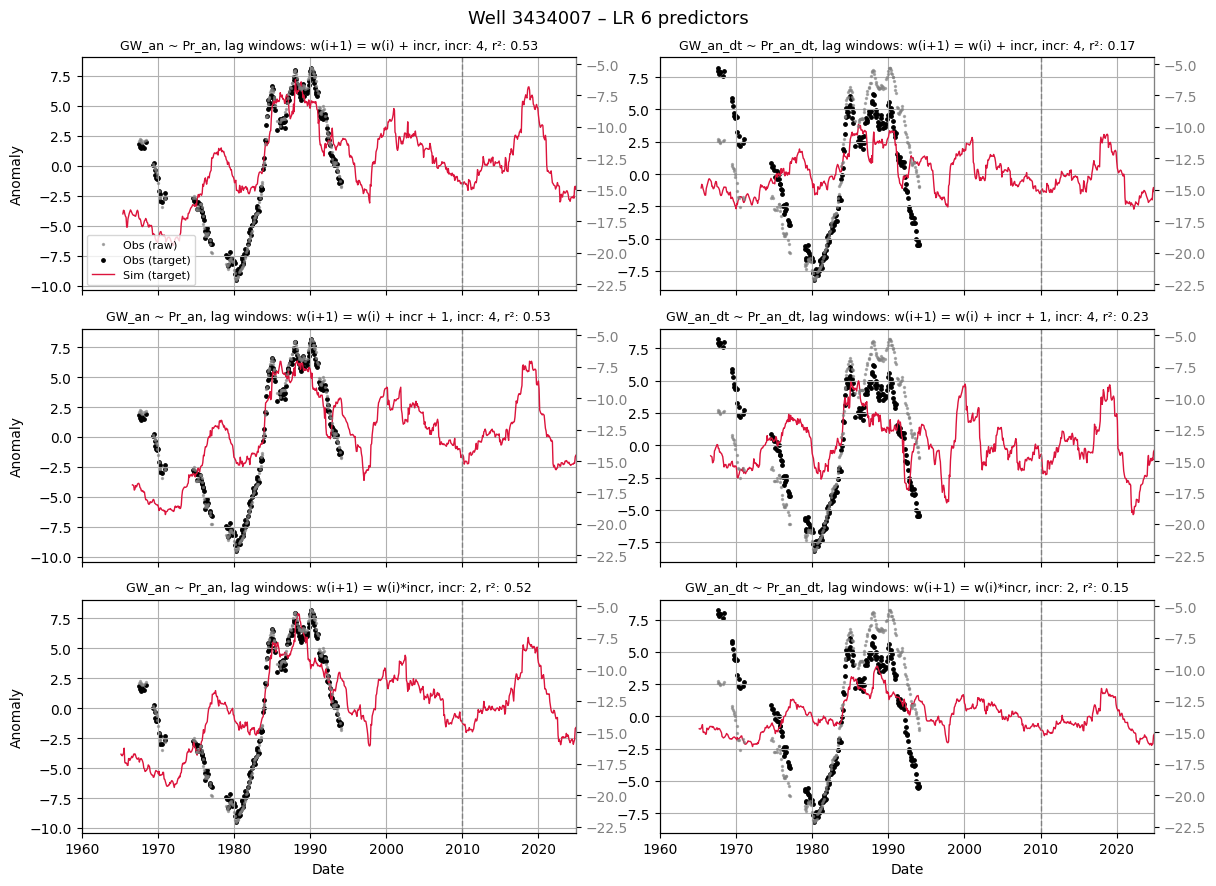

In [16]:
### CELL: Plot observed vs simulated time series per well

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

path_results = Path('csv')

# === Load data and where to save figures ===
# df = pd.read_csv(path_results / 'gw_sim_LR_trained_all.csv', parse_dates=['date'], dtype={'well_id': str})
# df_r2 = pd.read_csv(path_results / 'r2_LR_rest_pos_False_trained_all.csv', dtype={'well_id': str})
# out_dir = 'figs_obs_sim_trained_all'
# Path(out_dir).mkdir(parents=True, exist_ok=True)
# train_end = pd.to_datetime("2025-12-31")

# === Load data and where to save figures ===
df = pd.read_csv(path_results / 'gw_sim_LR_trained_pre_MD.csv', parse_dates=['date'], dtype={'well_id': str})
df_r2 = pd.read_csv(path_results / 'r2_LR_rest_pos_False_trained_pre_MD.csv', dtype={'well_id': str})
out_dir = 'figs_obs_sim_trained_pre_MD'
Path(out_dir).mkdir(parents=True, exist_ok=True)
train_end = pd.to_datetime("2009-12-31")

# === Define target/predictor pairs ===
combinations = [
    ('gw_an', 'pr_an', None, 'GW_an ~ Pr_an'),
    ('gw_an_dt', 'pr_an_dt', None, 'GW_an_dt ~ Pr_an_dt')
]

wells = df['well_id'].unique()
lag_types = df['lag_incr_rule'].unique()

# === Plot per well ===
eligible_wells = set(df_r2[df_r2['r2_all'] > 0.4]['well_id'].unique())
for cod in wells:
    if cod not in eligible_wells:
        continue
    subset_well = df[df['well_id'] == cod]
    if subset_well.empty:
        continue

    start, end = subset_well['date'].min(), subset_well['date'].max()
    fig, axs = plt.subplots(3, 2, figsize=(12, 9), sharex=True)
    axs = axs.ravel()

    for row, lag in enumerate(sorted(lag_types)):
        for col, (target, predictor, _, label) in enumerate(combinations):
            ax_idx = row * 2 + col
            ax = axs[ax_idx]

            combo_data = subset_well[
                (subset_well['lag_incr_rule'] == lag) &
                (subset_well['target'] == target) &
                (subset_well['predictor'] == predictor)
            ]

            if not combo_data.empty:
                incr = combo_data['lag_incr'].unique()[0]
                r2_row = df_r2[
                    (df_r2['well_id'] == cod) &
                    (df_r2['target'] == target) &
                    (df_r2['predictor'] == predictor) &
                    (df_r2['lag_incr_rule'] == lag)
                ]
                r2_all = r2_row['r2_all'].values[0] if not r2_row.empty else None
                title = f"{label}, lag windows: {lag}, incr: {incr}, r²: {r2_all:.2f}" if r2_all is not None else f"{label} ({lag}), R² = NA"

                p1 = ax.scatter(combo_data['date'], combo_data['target_val'], color='black', s=6, label='Obs (target)')
                p2, = ax.plot(combo_data['date'], combo_data['pred'], color='crimson', lw=1, label='Sim (target)')

                # Secondary: raw observations
                ax2 = ax.twinx()
                p3 = ax2.scatter(combo_data['date'], combo_data['raw_obs'], color='grey', s=2, alpha=0.6, label='Obs (raw)')
                ax2.tick_params(axis='y', labelcolor='grey')
                ax2.spines['right'].set_color('grey')
                ax2.yaxis.label.set_color('grey')

                # Training end line
                ax.axvline(train_end, color='grey', ls='--', lw=1)

                ax.set_title(title, fontsize=9)
                ax.grid(True)
                ax.set_xlim(start, end)

                if ax_idx == 0:
                    ax.legend(
                        handles=[p3, p1, p2],
                        labels=["Obs (raw)", "Obs (target)", "Sim (target)"],
                        fontsize=8,
                        loc='lower left',
                        frameon=True
                    )

                if col == 0:
                    ax.set_ylabel("Anomaly")
                if row == 2:
                    ax.set_xlabel("Date")
            else:
                ax.text(0.5, 0.5, "No data", ha='center', va='center')
                ax.set_axis_off()

    fig.suptitle(f"Well {cod} – LR 6 predictors", fontsize=13)
    plt.tight_layout()
    plt.savefig(out_dir / f"{cod}.png", bbox_inches='tight')
    plt.close()

print("LR Plots Finished! Finito! Terminado!")
